
# Human Vs Horses

In [3]:
#import library
import os
import zipfile
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
#https://matplotlib.org/users/image_tutorial.html
%matplotlib inline

In [4]:
#download and extract zip.
#https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
#https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip 

local_zip = 'horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('horse-or-human')

local_zip = 'validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('validation-horse-or-human/')
zip_ref.close()


One thing to pay attention to in this sample: We do not explicitly label the images as horses or humans. If you remember with the handwriting example earlier, we had labelled 'this is a 1', 'this is a 7' etc.  Later you'll see something called an ImageGenerator being used -- and this is coded to read images from subdirectories, and automatically label them from the name of that subdirectory. So, for example, you will have a 'training' directory containing a 'horses' directory and a 'humans' one. ImageGenerator will label the images appropriately for you, reducing a coding step. 

Let's define each of these directories:

In [5]:
train_horses_dir="horse-or-human/horses/"
train_humans_dir="horse-or-human/humans/"


train_horses_names=os.listdir(train_horses_dir)
train_humans_names=os.listdir(train_humans_dir)

In [6]:
validation_horses_dir="validation-horse-or-human/horses/"
validation_humans_dir="validation-horse-or-human/humans/"


validation_horses_names=os.listdir(validation_horses_dir)
validation_humans_names=os.listdir(validation_humans_dir)

In [7]:
print('total train horses images ',len(train_horses_names))
print('total train humans images ',len(train_humans_names))
print()
print('total valid horses images ',len(validation_horses_names))
print('total valid humans images ',len(validation_humans_names))

total train horses images  500
total train humans images  527

total valid horses images  128
total valid humans images  128


In [8]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

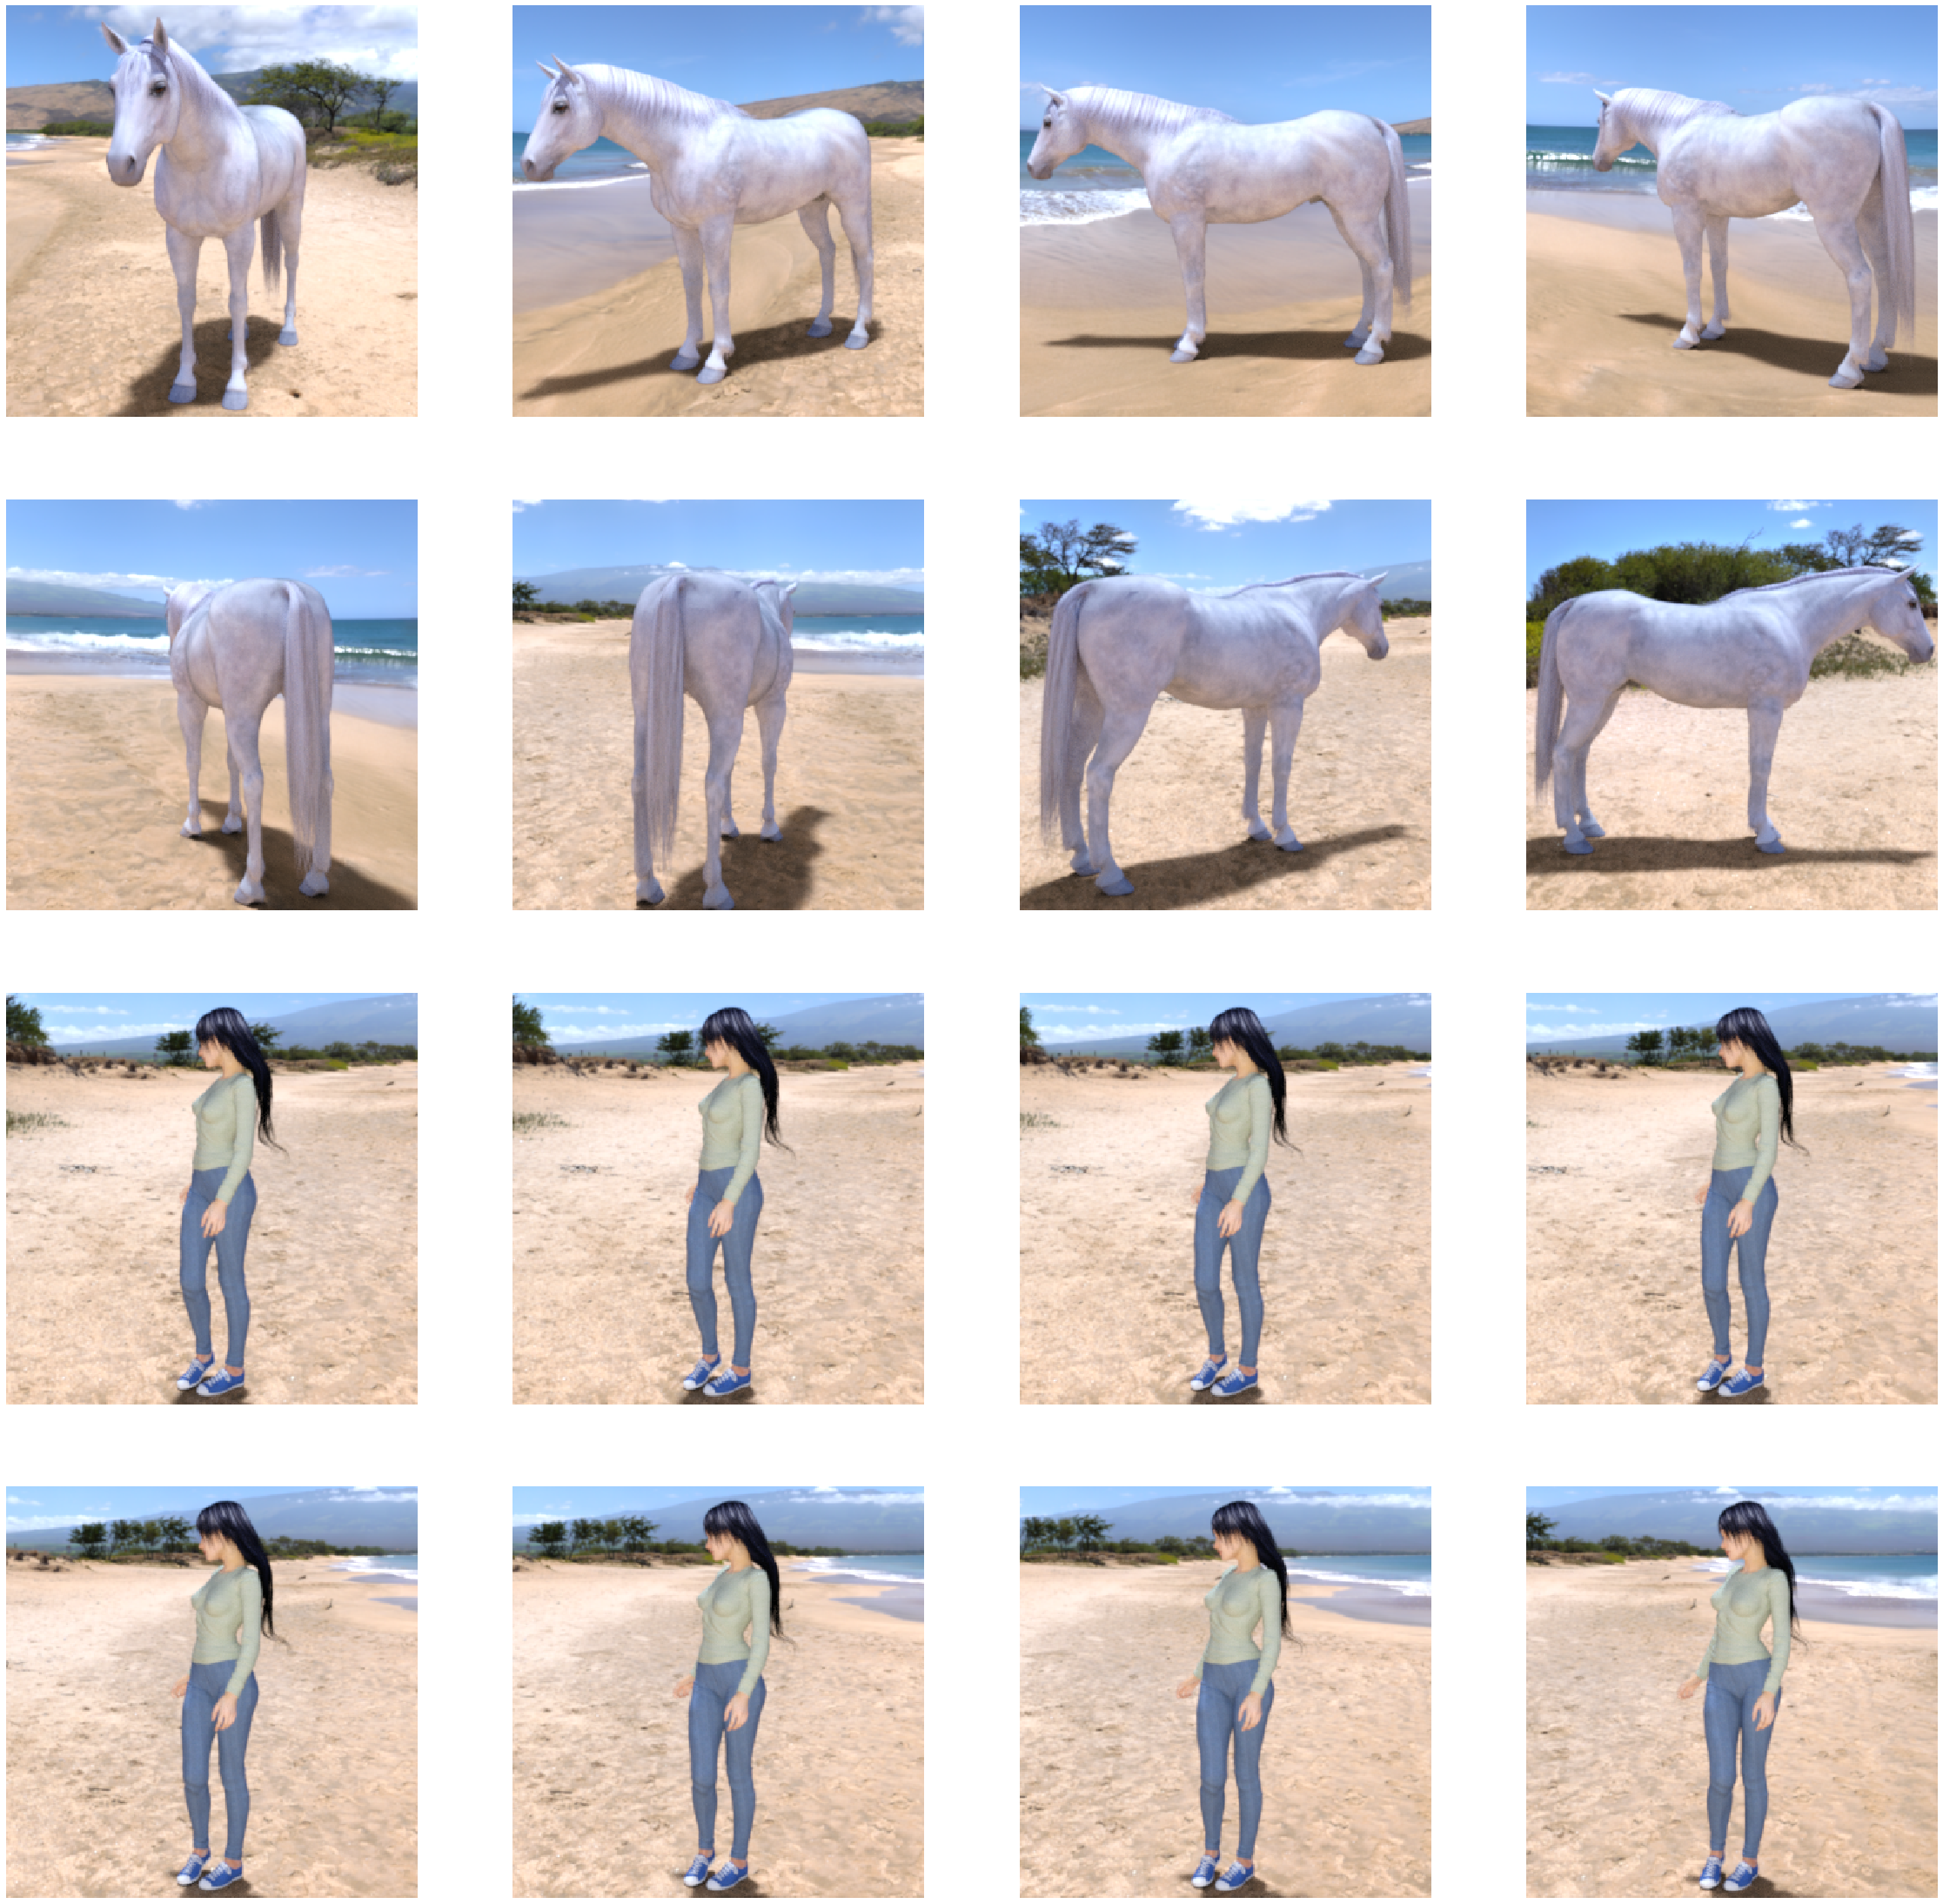

In [9]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 10, nrows * 10)

pic_index += 8
next_horse_pix = [os.path.join(train_horses_dir, fname) 
                for fname in train_horses_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_humans_dir, fname) 
                for fname in train_humans_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [10]:
img = mpimg.imread(train_horses_dir+train_horses_names[0])
img.shape

(300, 300, 4)

The "output shape" column shows how the size of your feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the dimensions.

In [11]:
model=tf.keras.models.Sequential([
    #First Convolution
    tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(300,300,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    #Second Convolution
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #Third Convolution
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #Fourth Convolution
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #Fifth Convolution
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512,activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1,activation='sigmoid')])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

In [13]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=0.001),metrics=['accuracy'])

### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of images of size 300x300 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit_generator`, `evaluate_generator`, and `predict_generator`.

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        'horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=256,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_datagen=ImageDataGenerator(rescale=1./255)
validation_generator=validation_datagen.flow_from_directory(
        'validation-horse-or-human/',
        target_size=(300,300),
        batch_size=32,
        class_mode='binary')


Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=8,  
      epochs=5,
      verbose=2,
      validation_data=validation_generator,
      validation_steps=8)

Epoch 1/5
8/8 - 371s - loss: 0.7596 - accuracy: 0.5844 - val_loss: 0.8984 - val_accuracy: 0.5000
Epoch 2/5


# Running the Model

Let's now take a look at actually running a prediction using the model. This code will allow you to choose 1 or more files from your file system, it will then upload them, and run them through the model, giving an indication of whether the object is a horse or a human.

In [ ]:
import numpy as np

test_images=os.listdir("horse-or-human-testimages/")
print(test_images)
# predicting images

for image in test_images:
    path = 'horse-or-human-testimages/'+image
    img=cv2.imread(path)
    img_resize=cv2.resize(img,(300,300))
    img_resize=img_resize/255.
    img_resize = np.expand_dims(img_resize, axis=0)
    images = np.vstack([img_resize])

    #cv2.waitKey(0)    cv2.imshow(image,img_resize)
    #cv2.destroyAllWindows()
    classes = model.predict(images, batch_size=10)
    print(classes[0])
    if classes[0]>0.5:
        print(image + " is a human")
    else:
        print(image + " is a horse")

### Visualizing Intermediate Representations

To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet.

Let's pick a random image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

In [ ]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horses_dir, f) for f in train_horses_names]
human_img_files = [os.path.join(train_humans_dir, f) for f in train_humans_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')